## Import librairies

In [1]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer


pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [2]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [3]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14604\3374211802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


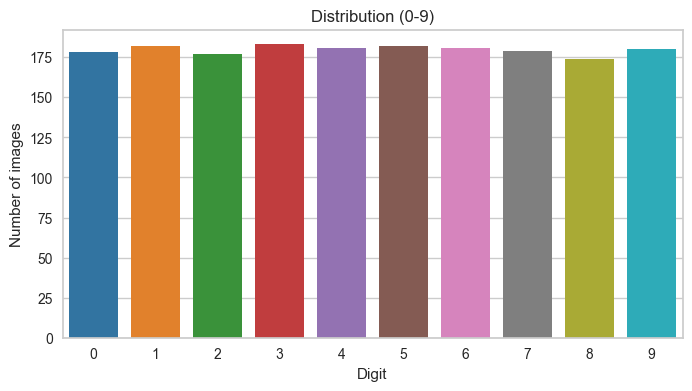

In [4]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

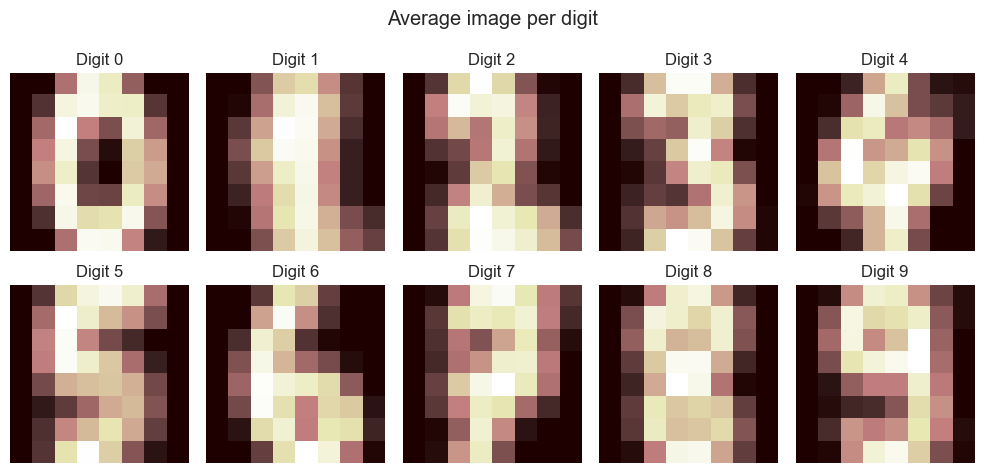

In [5]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='pink')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

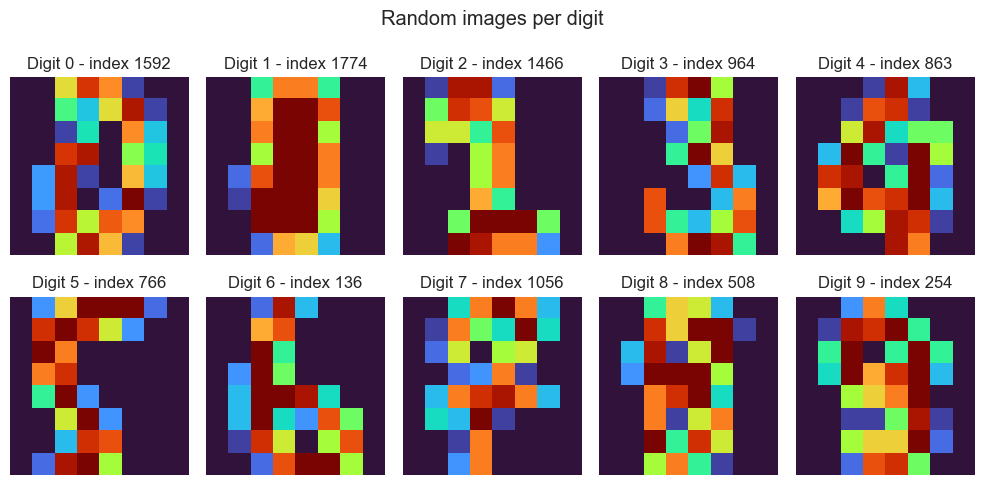

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='turbo')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();
# on peut utiliser la library opencv pour faire le resizing au cas ou les images n'ont pas

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [7]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]


    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [8]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=0.99).fit(X) # Aide moi à choisir les axes qui donnent au total 99% des informations
kmeans = KMeans(#init=pca.components_,
                n_clusters=n_digits, n_init= 4)
bench_k_means(kmeans=kmeans, name="PCA-based", data=pca.transform(X), labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.909s	4647	0.739	0.747	0.743	0.669	0.174
random   	0.044s	4648	0.735	0.742	0.738	0.667	0.187
PCA-based	0.070s	1297	0.761	0.768	0.764	0.690	0.182
__________________________________________________________________________________


## Optimal number of clusters

In [9]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

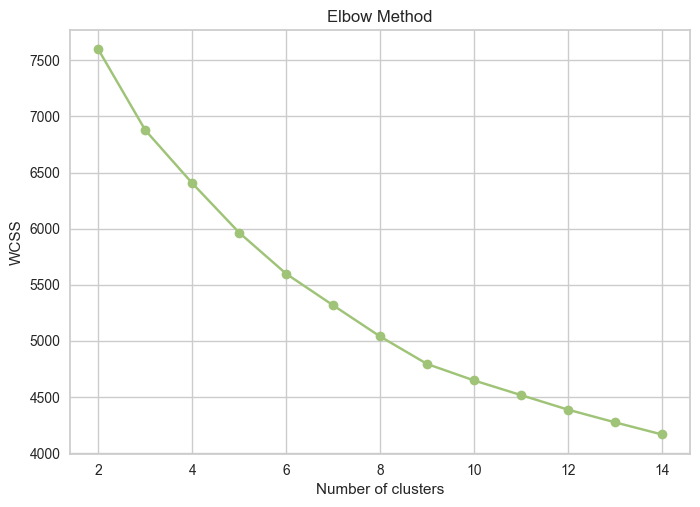

In [10]:
wcss = []  # Within-Cluster Sum of Squares

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

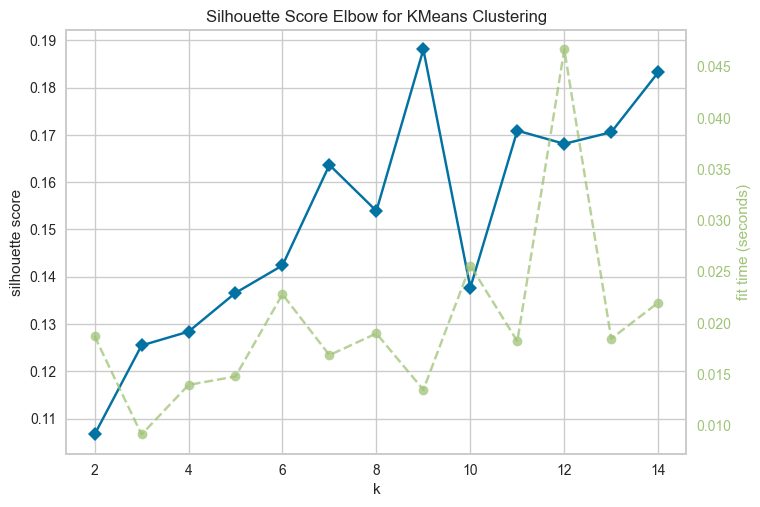

In [11]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion


visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [12]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [13]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,8
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,7
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,6
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,3


In [14]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,160,0,0,0,0,5,8,0,0,0
1,0,9,10,13,3,26,0,117,24,9
2,4,6,4,20,0,48,0,0,8,94
3,1,4,0,0,144,2,21,1,1,0
4,1,29,35,11,0,45,0,1,72,17
5,12,0,0,0,24,5,150,0,0,1
6,0,0,2,95,0,0,0,0,0,41
7,0,47,12,0,5,47,2,39,62,10
8,0,87,1,0,5,0,0,21,4,0


In [15]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    0
1    7
2    9
3    4
4    8
5    6
6    3
7    8
8    1
9    2
dtype: int64


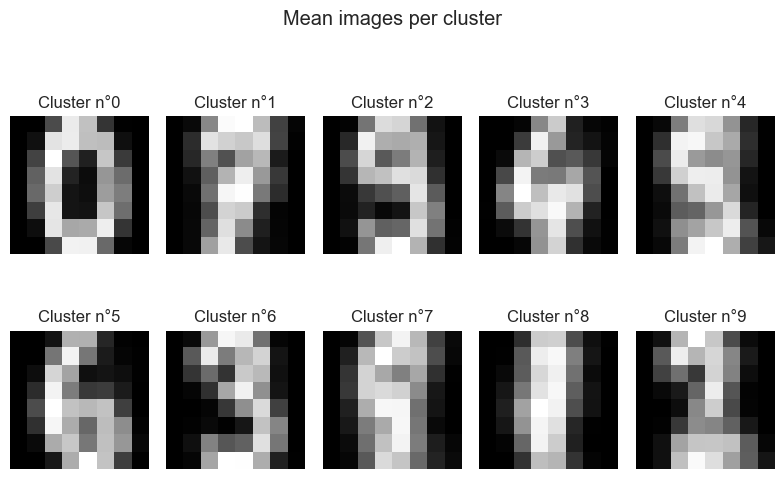

In [16]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)

    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')

plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

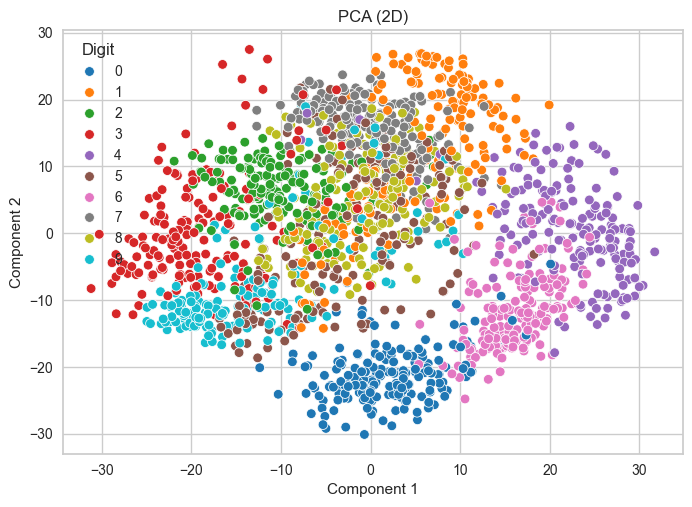

In [17]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


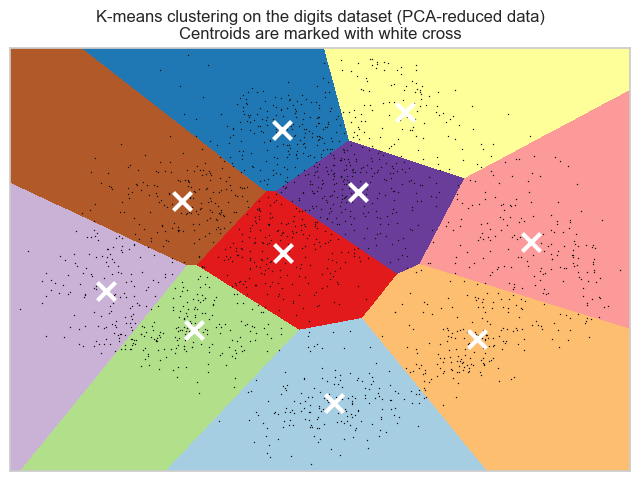

In [18]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

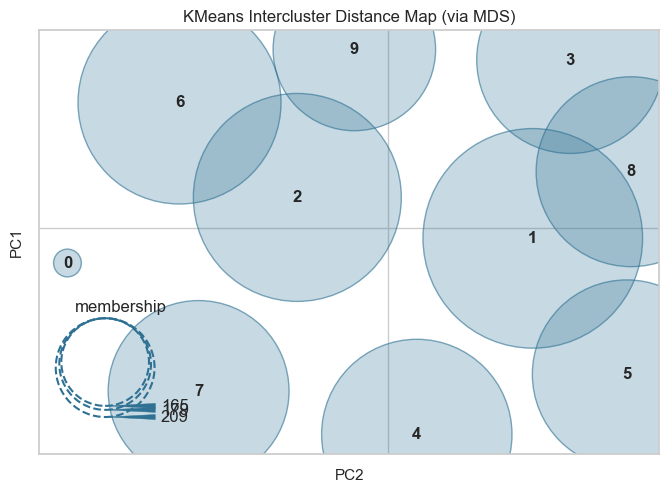

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [19]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [20]:
from sklearn.manifold import TSNE

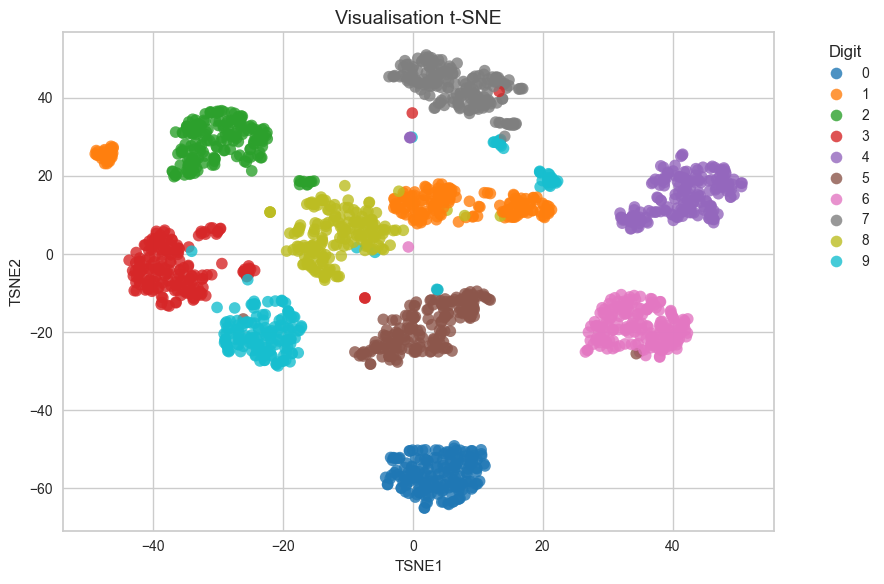

In [21]:
# Initialize
tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric='euclidean')
X_tsne = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels # Conversion en string pour une discrétisation catégorielle

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Optimisation de kmeans à au moins 3 composantes avec ou sans reduction de dimension
comparer plusieurs méthodes de standardistation
choix du meilleur modèle (méthode)
Analyse du persona
Optimisation de Kmeans avec ou sans pca

objet:TP ISE-Clusturing 2025

# TP2 CLUSTERING

### Optimisation de K-means avec différents hyperparamètres

Cette partie est destinéeà l'optimisation des hyperparametres pour le K-means. Nous optimisons 4 hyperparametres (le nombre de clusters, la méthode d'initialisation, le nombre de classe initiales avec K-means, le nombre d'itérations maximal à réaliser). Egalement nous testons à l'aide d'une boucle différentes méthodes de standardisation et la réduction ou non des données. L'ensemble des résulats sont stockés dans un dataframe.

La métrique utilisée pour optimiser le modèle est la métrique d'ARI (Adjusted Rand Index). Puisque nous avons les vrais labels, au dela du clustering simple, le modèle sera d'autant meilleur qu'il permet d'associer une image à son vrai label. C'est donc ce que nous allons mesurer pour le modèle de clustering.
Egalement, après des test c'est laa métrique qui nous donne des cluster plus homogènes (pureté) et c'est ce qui est souhaité.

In [36]:
# Paramètres à optimiser
parametres = {
    'n_clusters': [8, 9, 10, 11, 12],      # Nombre de clusters
    'init': ['k-means++', 'random'],       # Méthode d'initialisation
    'n_init': [4, 8, 9, 10, 20],           # Nombre d'initialisations avec différentes centroïdes
    'max_iter': [100, 300, 500]            # Nombre maximum d'itérations
}

# Liste pour stocker les résultats
resultats = []

# Définition des scalers à tester
scalers = [
    ("Sans scaling", None),
    ("MinMaxScaler", MinMaxScaler()),
    ("StandardScaler", StandardScaler()),
    ("RobustScaler", RobustScaler())
]

# Définition des configurations de PCA à tester
pca_configs = [
    ("Sans PCA", None),
    ("Avec PCA", PCA(n_components=0.99))  # Conserver 99% de la variance
]

In [38]:
# Tester toutes les combinaisons
meilleur_score = -1
meilleur_score_s = -1

meilleure_config = None
meilleur_kmeans = None
meilleur_X = None

for scaler_name, scaler in scalers:
    for pca_name, pca in pca_configs:
        print(f"\nTest avec {scaler_name} et {pca_name}")
        
        # Prétraitement des données
        if scaler is not None:
            X_scaled = scaler.fit_transform(X)
        else:
            X_scaled = X.copy()
            
        if pca is not None:
            X_processed = pca.fit_transform(X_scaled)
            print(f"  Dimensions après PCA: {X_processed.shape[1]}")
        else:
            X_processed = X_scaled
        
        # Tester différentes valeurs de hyperparamètres
        for n_clusters in parametres['n_clusters']:
            for init_method in parametres['init']:
                for n_init in parametres['n_init']:
                    for max_iter in parametres['max_iter']:
                        # Création et entraînement du modèle
                        kmeans = KMeans(
                            n_clusters=n_clusters,
                            init=init_method,
                            n_init=n_init,
                            max_iter=max_iter,
                            random_state=42
                        )
                    
                    t0 = time()
                    kmeans.fit(X_processed)
                    duree = time() - t0
                    
                    # Évaluation du modèle
                    inertie = kmeans.inertia_
                    labels_pred = kmeans.labels_
                    silhouette = metrics.silhouette_score(X_processed, labels_pred)
                    ari = metrics.adjusted_rand_score(labels, labels_pred)
                    # Stocker les résultats
                    config = {
                        'scaler': scaler_name,
                        'pca': pca_name,
                        'n_clusters': n_clusters,
                        'init': init_method,
                        'n_init': n_init,
                        'max_iter': max_iter,
                        'inertie': inertie,
                        'silhouette': silhouette,
                        'ari' : ari, 
                        'duree': duree
                    }
                    resultats.append(config)
                    
                    # Vérifier si c'est le meilleur modèle jusqu'à présent
                    if ari > meilleur_score:
                        meilleur_score = ari
                        meilleur_score_s = silhouette
                        meilleure_config = config
                        meilleur_kmeans = kmeans
                        meilleur_X = X_processed


Test avec Sans scaling et Sans PCA

Test avec Sans scaling et Avec PCA
  Dimensions après PCA: 41

Test avec MinMaxScaler et Sans PCA

Test avec MinMaxScaler et Avec PCA
  Dimensions après PCA: 44

Test avec StandardScaler et Sans PCA

Test avec StandardScaler et Avec PCA
  Dimensions après PCA: 54

Test avec RobustScaler et Sans PCA

Test avec RobustScaler et Avec PCA
  Dimensions après PCA: 42


In [39]:
# Convertir en DataFrame pour une meilleure lisibilité
resultats_df = pd.DataFrame(resultats)
print("\nTop 5 des meilleurs modèles par score ARI:")
print(resultats_df.sort_values('ari', ascending=False).head())
#print(resultats_df.sort_values('silhouette', ascending=False).head())
print("\nMeilleure configuration:")
for key, value in meilleure_config.items():
    print(f"  {key}: {value}")


Top 5 des meilleurs modèles par score ARI:
           scaler       pca  n_clusters       init  n_init  max_iter  \
80   Sans scaling  Avec PCA          11  k-means++       4       500   
480  Sans scaling  Avec PCA          11  k-means++       4       500   
189  MinMaxScaler  Avec PCA          11     random      20       500   
589  MinMaxScaler  Avec PCA          11     random      20       500   
134  MinMaxScaler  Sans PCA          11  k-means++      20       500   

          inertie  silhouette       ari     duree  
80   1.110900e+06    0.186477  0.741680  0.072949  
480  1.110900e+06    0.186477  0.741680  0.066318  
189  4.439719e+03    0.184421  0.734769  0.191469  
589  4.439719e+03    0.184421  0.734769  0.221376  
134  4.515158e+03    0.181390  0.734033  0.415000  

Meilleure configuration:
  scaler: Sans scaling
  pca: Avec PCA
  n_clusters: 11
  init: k-means++
  n_init: 4
  max_iter: 500
  inertie: 1110900.1905537413
  silhouette: 0.1864774850535455
  ari: 0.74168014446

### 2. Analyse des personas pour le meilleur modèle

Le meilleure modèle obtenu a un score **d'ARI**  de **74,17 %** et un silhouette score de 18,65 %. Le nombre optimal de cluster est 11 obtenu avec une initialisation avec la méthode kmeans++ avec 4 clusters initiaux et après 500 itérations.

In [42]:
# Ajouter les étiquettes de clusters optimisés au DataFrame original
meilleures_etiquettes = meilleur_kmeans.labels_
data["cluster_optimise"] = meilleures_etiquettes

In [43]:
# Créer une table de contingence pour voir la correspondance entre clusters et chiffres
contingency_table_optimisee = pd.crosstab(data["cluster_optimise"], data["label"])
print("Table de contingence (clusters vs chiffres réels):")
print(contingency_table_optimisee)

Table de contingence (clusters vs chiffres réels):
label               0    1    2    3    4    5    6    7    8    9
cluster_optimise                                                  
0                   0   24  147    1    0    0    0    0    2    0
1                   0    0    1    7    0   40    0    0    3  143
2                   0    0   13    7    1    0    1    0  142    2
3                   0    2    0    0    0    2  176    0    1    0
4                   0   54    2    0    7    0    0    2    4   20
5                 177    0    1    0    0    0    1    0    0    0
6                   0  100    1    1    5    0    3    2   15    0
7                   1    0    0    0  160    2    0    0    0    0
8                   0    1   10  158    0    1    0    0    0    2
9                   0    1    0    2    0  137    0    1    5    5
10                  0    0    2    7    8    0    0  174    2    8


In [44]:
# Identifier le chiffre principal pour chaque cluster
chiffre_principal = contingency_table_optimisee.idxmax(axis=1)
print("\nChiffre principal par cluster:")
print(chiffre_principal)


Chiffre principal par cluster:
cluster_optimise
0     2
1     9
2     8
3     6
4     1
5     0
6     1
7     4
8     3
9     5
10    7
dtype: int64


In [45]:
# Calculer la pureté de chaque cluster (% du chiffre principal)
purete = contingency_table_optimisee.max(axis=1) / contingency_table_optimisee.sum(axis=1) * 100
print("\nPureté de chaque cluster (%):")
print(purete.round(2))


Pureté de chaque cluster (%):
cluster_optimise
0     84.48
1     73.71
2     85.54
3     97.24
4     60.67
5     98.88
6     78.74
7     98.16
8     91.86
9     90.73
10    86.57
dtype: float64


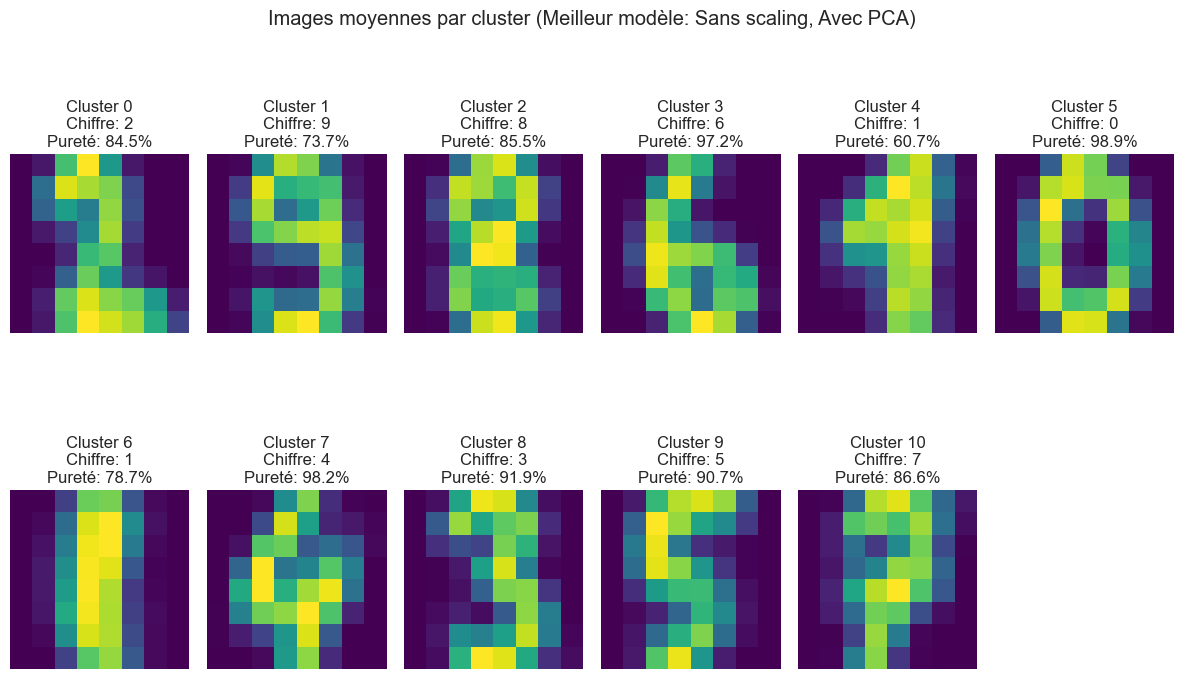

In [48]:
# Visualiser les images moyennes par cluster
n_clusters = meilleur_kmeans.n_clusters
plt.figure(figsize=(12, 8))
plt.suptitle(f"Images moyennes par cluster (Meilleur modèle: {meilleure_config['scaler']}, {meilleure_config['pca']})")
for cluster_id in range(n_clusters):
    cluster_indices = np.where(meilleures_etiquettes == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 6, cluster_id + 1)
    plt.imshow(mean_image, cmap='viridis')
    plt.title(f"Cluster {cluster_id}\nChiffre: {chiffre_principal[cluster_id]}\nPureté: {purete[cluster_id]:.1f}%")
    plt.axis('off')

plt.tight_layout()
plt.show()

D'abord, nous avons au total 11 cluster alors que les vrais labels montrent qu'il y'a  10 chiffres. Chaque label  est au moins le label principal dans un cluster. C'est le chiffre 1 qui se retouve dans 2 cluster comme label pincipal. Cela semble se justifiée car la visualisation des profils moyens montre qu'il y'a différents types de 1. Certains n'ont que la lige verticale et non la ligne obique en plus.

Egalement en obsevant les profils moyens on voit que chaqu'on peut idenifier le label correspondant. le clusturing est donc globalement bon.

### 3. Visualisation avec t-SNE

Application de t-SNE...


c:\Users\LENOVO\Desktop\ISE2\semestre2\ML2\TP1\env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE terminé en 16.59 secondes


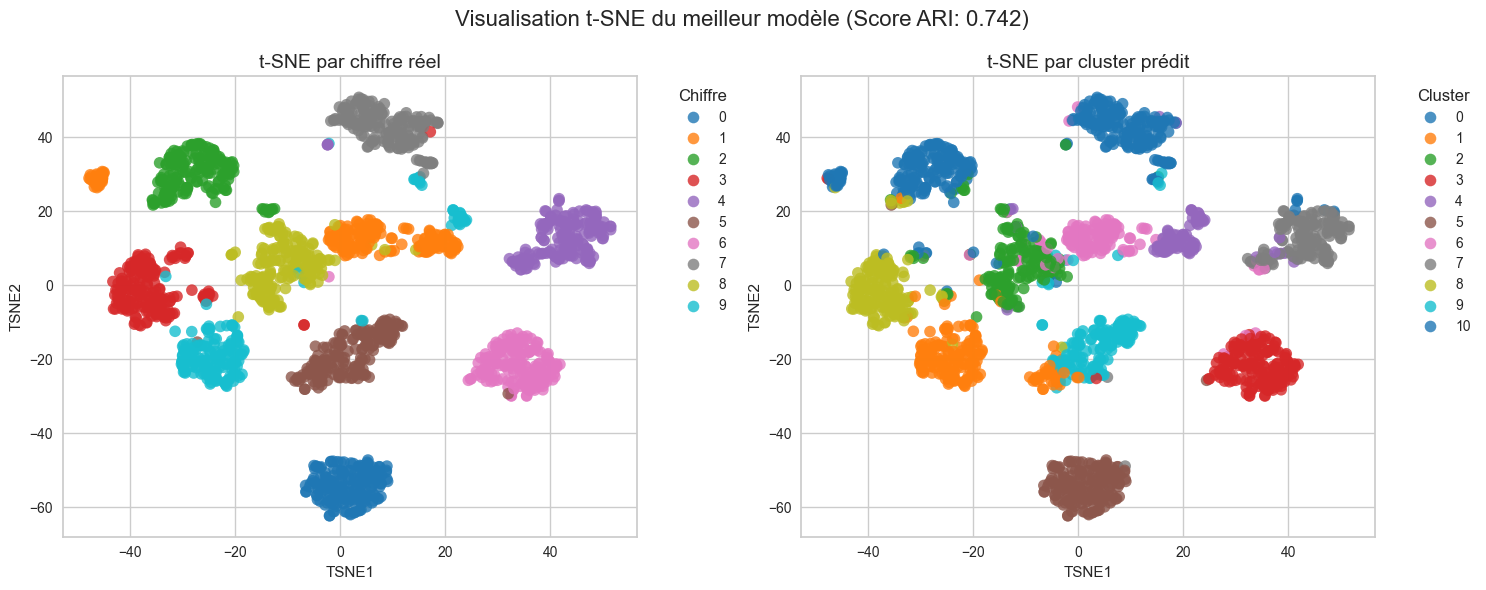

In [49]:
# Appliquer t-SNE sur les données prétraitées du meilleur modèle
print("Application de t-SNE...")
t0 = time()
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(meilleur_X)
print(f"t-SNE terminé en {time() - t0:.2f} secondes")

# Créer un DataFrame pour la visualisation avec t-SNE
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels  # Étiquettes réelles
df_tsne['cluster'] = meilleures_etiquettes  # Clusters prédits

# Visualisation t-SNE des étiquettes réelles vs clusters
plt.figure(figsize=(15, 6))

# Visualisation t-SNE avec les étiquettes réelles
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('t-SNE par chiffre réel', fontsize=14)
plt.legend(title='Chiffre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Visualisation t-SNE avec les clusters prédits
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='cluster',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('t-SNE par cluster prédit', fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle(f"Visualisation t-SNE du meilleur modèle (Score ARI: {meilleur_score:.3f})", fontsize=16)
plt.tight_layout()
plt.show()



### 4. Analyse des clusters choisies

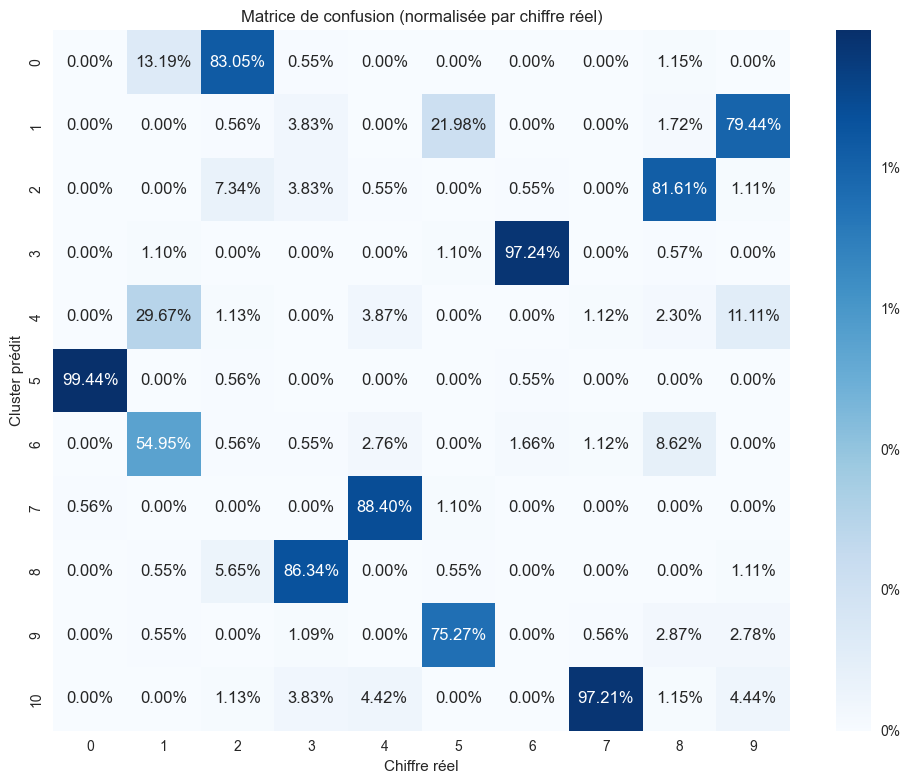

In [50]:
# Normaliser par colonne (chaque chiffre réel)
matrice_confusion = contingency_table_optimisee.div(contingency_table_optimisee.sum(axis=0), axis=1)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_confusion, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=sorted(data['label'].unique()),
            yticklabels=sorted(data['cluster_optimise'].unique()),
            cbar_kws={'format': '%.0f%%'})  # Affichage du pourcentage dans la barre de couleur

plt.xlabel('Chiffre réel')
plt.ylabel('Cluster prédit')
plt.title('Matrice de confusion (normalisée par chiffre réel)')
plt.tight_layout()
plt.show()


il ressort principalement que le chiffre 1 est le plus dispersé. le cluster 6 qui le contient en majorité n'en contient que  54,95%. le cluster qui contient la seconde partie en majorit est e cluster 4 à 29,67 %. A part ce chiffre les chiffres 5 et 9 ne sont pas contenus qu'à 75,27% et 79,44% dans leur clusters respectifs ce qui est quand même acceptable. Pour les chiffres restant on est à pkus de 80%

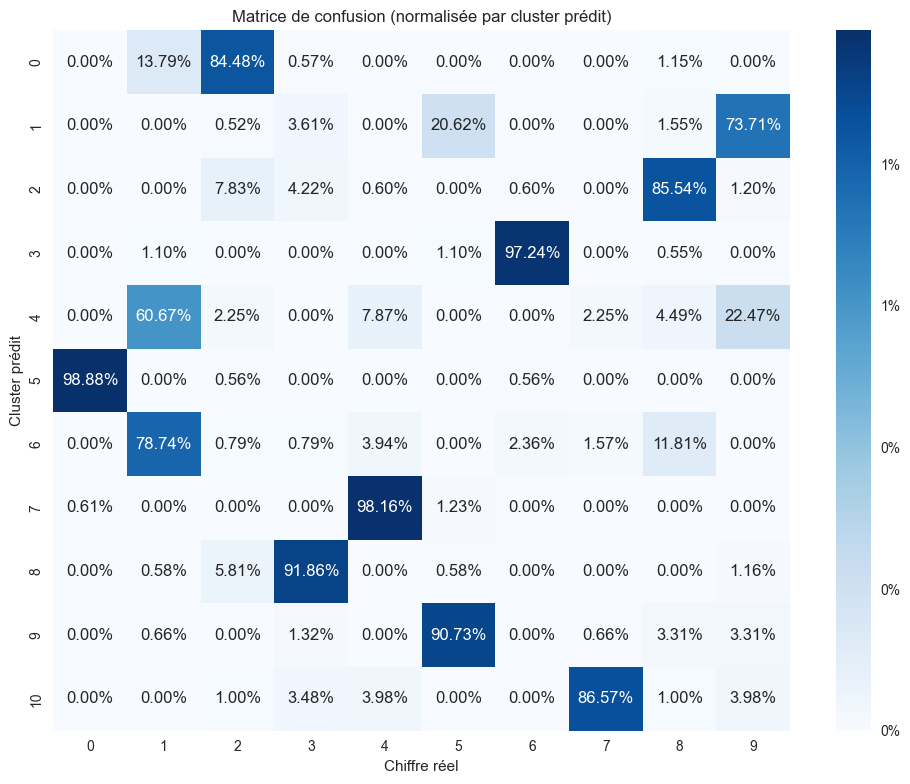

In [52]:
# Normaliser par ligne (chaque cluster prédit)
matrice_confusion = contingency_table_optimisee.div(contingency_table_optimisee.sum(axis=1), axis=0)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_confusion, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=sorted(data['label'].unique()),
            yticklabels=sorted(data['cluster_optimise'].unique()),
            cbar_kws={'format': '%.0f%%'})  # Affichage du pourcentage dans la barre de couleur

plt.xlabel('Chiffre réel')
plt.ylabel('Cluster prédit')
plt.title('Matrice de confusion (normalisée par cluster prédit)')
plt.tight_layout()
plt.show()


Tous les cluster ont un degré d'homogénéité supérieur à 60,67%. Ce score a d'ailleurs été obtenu pour un cluster du chiffre 1 qui se restrouve correspondre à deux clusters le second ayant 78,74% de pureté. l'analyse montre que le chiffre 9  est parfois interpreté comme étant un chiffre 1 qui a un batonné oblique et le chiffre 8 comme un 1 sans batonnet donc vertical. Le chiffre 5 lui parfois interpreté comme 9. Le reste des chiffres sont globalement biens interpreté (pueté supérieur à 80%). 


Affichage de quelques exemples par cluster...


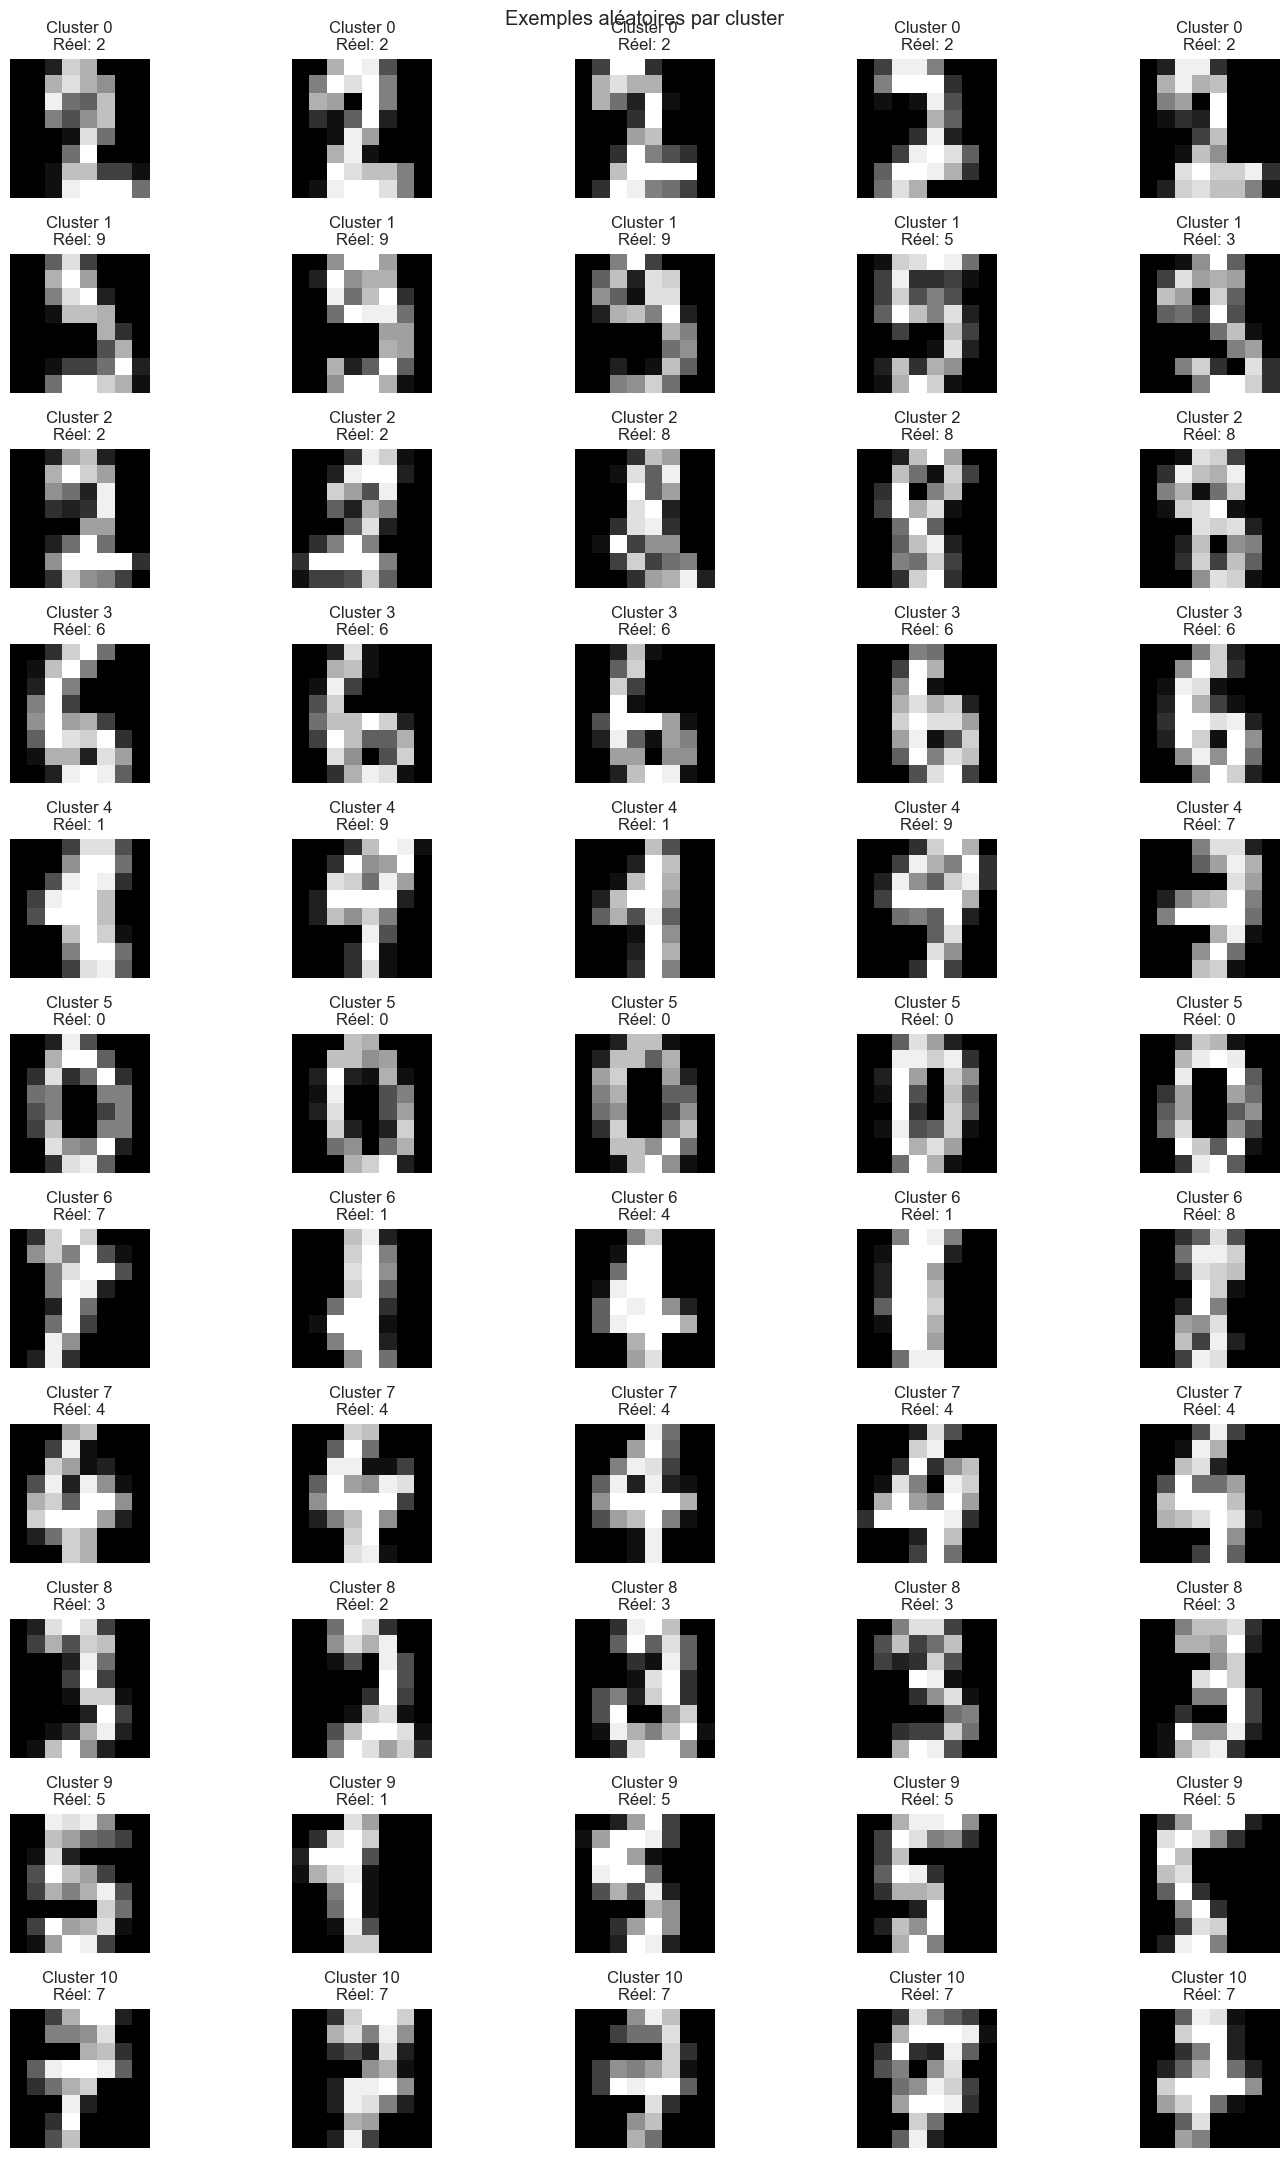

In [53]:
# Afficher quelques exemples spécifiques de chaque cluster
print("\nAffichage de quelques exemples par cluster...")
plt.figure(figsize=(15, n_clusters*2))

for cluster_id in range(n_clusters):
    cluster_indices = np.where(meilleures_etiquettes == cluster_id)[0]
    n_examples = min(5, len(cluster_indices))
    random_indices = np.random.choice(cluster_indices, n_examples, replace=False)
    
    for j, idx in enumerate(random_indices):
        plt.subplot(n_clusters, 5, cluster_id*5 + j + 1)
        plt.imshow(X[idx].reshape(8, 8), cmap='gray')
        plt.title(f"Cluster {cluster_id}\nRéel: {labels[idx]}")
        plt.axis('off')

plt.suptitle("Exemples aléatoires par cluster")
plt.tight_layout()
plt.show()

In [54]:
print("\nConclusion:")
print(f"Le meilleur modèle utilise {meilleure_config['scaler']} et {meilleure_config['pca']}")
print(f"avec {meilleure_config['n_clusters']} clusters, initialization {meilleure_config['init']}")
print(f"n_init={meilleure_config['n_init']}, max_iter={meilleure_config['max_iter']}")
print(f"et score ari de {meilleur_score:.3f}")
print(f"La pureté moyenne des clusters est de {purete.mean():.1f}%")


Conclusion:
Le meilleur modèle utilise Sans scaling et Avec PCA
avec 11 clusters, initialization k-means++
n_init=4, max_iter=500
et score ari de 0.742
La pureté moyenne des clusters est de 86.1%
